* Precinct returns: http://sos-tn-gov-files.s3.amazonaws.com/StateGeneralbyPrecinctNov2016.xlsx
* KMZ are split by counties.  The location has changed since I downloaded these.  The landing page is now: https://apps.cot.tn.gov/DPAMaps/Redistrict/Counties
* These can be downloaded and converted to shapefiles using the bash (wget + ogr2ogr) script pasted at the end.  Note that that url is the old one.  It would have to be updated slightly with the new site, but the structure seems to be the same.  In addition, these are the "current" precincts, which may have changed since August 2017 when I downloaded them.

In [1]:
import sys; sys.path.insert(0,'../')
from dist_tools import *

%matplotlib inline

In [2]:
usps, seats, fips, epsg = "TN", 9, 47, 3661

In [3]:
counties = []

fname = "/media/jsaxon/brobdingnag/data/el_dv/tn_site/"

for shp in glob.glob(fname + "*shp"):
    
    print(shp.replace(fname, "").replace(".shp", ""), end = " ")
    if "tennessee" in shp: continue

    counties.append(gpd.read_file(shp)[["Name", "geometry"]])
    counties[-1].crs = from_epsg(4269)
    counties[-1] = counties[-1].to_crs(epsg = 3661)
    counties[-1]["county"] = shp.replace(fname, "").replace(".shp", "")
    counties[-1].rename(columns = {"Name" : "name"}, inplace = True)
    
    if "Van" in shp: counties[-1]["county"] = "Van Buren"


Jefferson Blount Coffee Cannon Hamilton Hardeman Roane Marshall Lewis Robertson Grainger Clay Macon Cocke Henderson Decatur Fayette Johnson Lake Chester Smith Perry Dickson Lauderdale Henry Shelby Hardin Scott Rhea Wayne Union Crockett Bedford Benton Monroe Williamson Carter Grundy Weakley Haywood Sullivan DeKalb Sevier Loudon Franklin Lawrence Davidson Anderson Obion Bledsoe Meigs Bradley Cumberland Putnam Hamblen Maury McNairy Madison Giles White Tipton Pickett Trousdale Sequatchie Rutherford tennessee Cheatham Knox Overton Greene Morgan Claiborne Washington Sumner Humphreys Moore Marion Polk Unicoi Warren Hancock Hickman Wilson Campbell Dyer Fentress Stewart Lincoln Hawkins Jackson Houston Carroll McMinn VanBuren Montgomery Gibson 

In [4]:
tn = pd.concat(counties)
tn.sort_values(by = ["county", "name"], inplace = True)

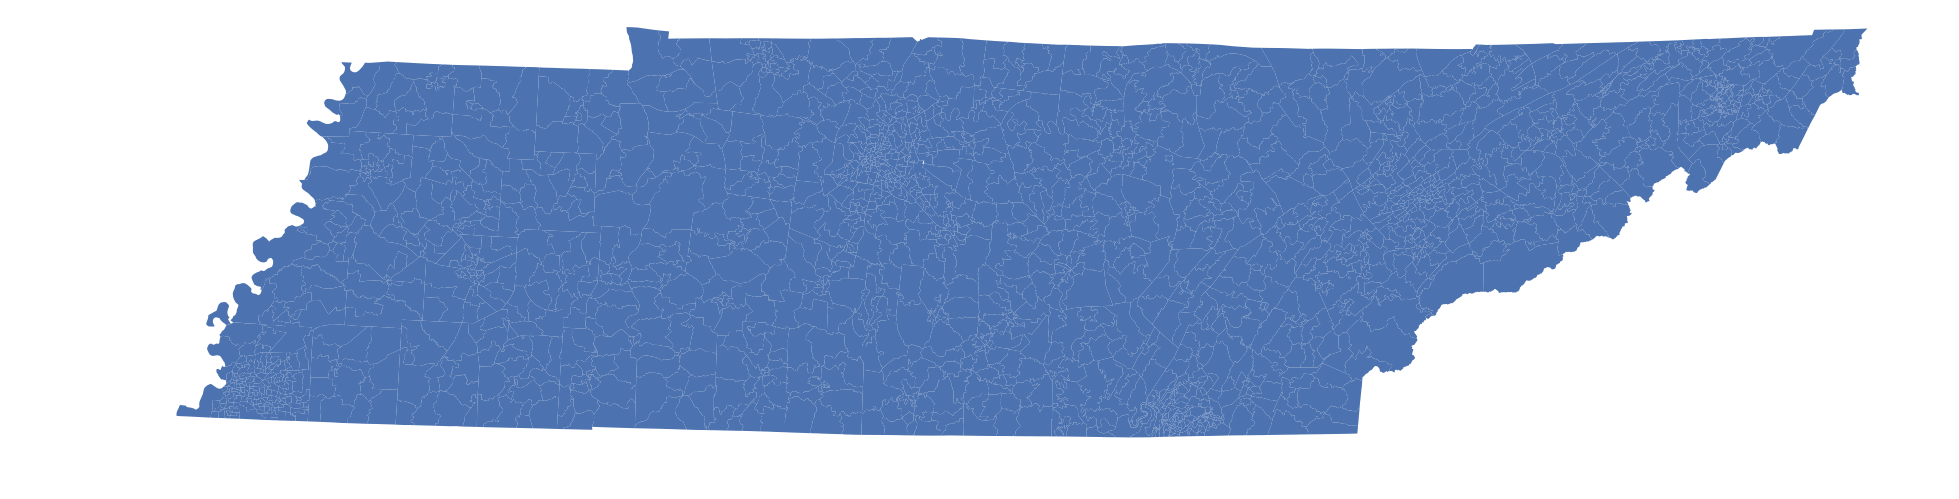

In [5]:
tn.plot(figsize = (16, 16), linewidth = 0.03).set_axis_off()

In [6]:
# tn.set_geometry(tn.centroid, inplace = True)
# tn.to_file(fname + "tennessee.shp")

In [7]:
# tn = gpd.read_file(fname + "tennessee.shp")

In [8]:
tn_votes = pd.read_csv(fname + "20161108__tn__general__precinct.csv")
tn_votes = tn_votes[tn_votes.office == "United States President"][["county", "precinct", "party", "votes"]]
tn_votes["party"] = tn_votes.party.replace({"Democratic" : "D16", "Republican" : "R16"})
tn_votes = tn_votes[tn_votes.party.str.contains("R16") | tn_votes.party.str.contains("D16")][["county", "precinct", "party", "votes"]]
tn_votes = pd.pivot_table(tn_votes, values = "votes", index = ["county", "precinct"], columns = ["party"])
tn_votes = tn_votes.reset_index()
tn_votes = tn_votes[(tn_votes.D16 + tn_votes.R16) > 0]

In [9]:
import jellyfish as jf

def jf_jw_match(x, list_strings):
    return sorted(list_strings, key=lambda y: jf.jaro_winkler(x, y), reverse = True)[0]

In [10]:
tn.loc[(tn.county == "Anderson") & (tn.name == "Lake City MS"), "name"] = "Lake City Middle School"
tn.loc[(tn.county == "Anderson") & (tn.name == "Lake City"), "name"] = "Rocky Top" # Town changed its name 2014.

tn.loc[(tn.county == "Benton") & tn.name.str.contains("5"), "name"] = "5 Library"
tn.loc[(tn.county == "Benton") & tn.name.str.contains("3"), "name"] = "3 Camden City Hall"

tn_votes.loc[tn_votes.county == "Bledsoe", "precinct"] = tn_votes.loc[tn_votes.county == "Bledsoe", "precinct"].str.replace("[1-6]-[1-3] ", "")
tn_votes.loc[(tn_votes.county == "Blount") & tn_votes.precinct.str.contains("Wm"), "precinct"] = "William Blount Academy"
tn.loc[(tn.county == "Bradley"), "name"] = tn.loc[(tn.county == "Bradley"), "name"].str.replace("0", "-").str.replace("5 Points ", "")
tn.loc[(tn.county == "Campbell"), "name"] = tn.loc[(tn.county == "Campbell"), "name"].str.replace("Campbell County High School", "3-1 CCHS").str.replace("Elementary School", "ES")
tn.loc[(tn.county == "Cannon"), "name"] = tn.loc[(tn.county == "Cannon"), "name"].str.replace(r"^([24]) ", r"\1- ")
tn.loc[(tn.county == "Carroll"), "name"] = tn.loc[(tn.county == "Carroll"), "name"].str.replace(r"^[0-9]+ ", r"")
tn.loc[(tn.county == "Carroll") & (tn.name == "City Hall/Big Buck"), "name"] = "Huntingdon"
tn.loc[(tn.county == "Coffee") & tn.name.str.contains("20"), "name"] = "20 Sr Citizens Center"
tn_votes.loc[(tn_votes.county == "Crockett"), "precinct"] = tn_votes.loc[(tn_votes.county == "Crockett"), "precinct"].str.replace("^0", "")
tn_votes.loc[(tn_votes.county == "Davidson"), "precinct"] = tn_votes.loc[(tn_votes.county == "Davidson"), "precinct"].str.replace("^0", "")#.str.replace("^3-5", "3-1")
tn.loc[(tn.county == "Franklin") & tn.name.str.contains("3-3"), "name"] = "3-3 Walnut Grove"
tn.loc[(tn.county == "Gibson"), "name"] = tn.loc[(tn.county == "Gibson"), "name"].str.replace("^[0-9\-]+ ", "").str.replace("High School", "HS")
tn.loc[(tn.county == "Gibson") & tn.name.str.contains("Humboldt Lane Chapel"), "name"] = "Lane Chapel Church"
tn_votes.loc[(tn_votes.county == "Gibson") & tn_votes.precinct.str.contains("Currie"), "precinct"] = "Currie"
tn_votes.loc[(tn_votes.county == "Hamilton"), "precinct"] = tn_votes.loc[(tn_votes.county == "Hamilton"), "precinct"].str.replace(r"[0-9]+ ", "")
tn_votes.loc[(tn_votes.county == "Hardin"), "precinct"] = tn_votes.loc[(tn_votes.county == "Hardin"), "precinct"].str.replace(r"^([A-z ]+) ([0-9])-[1-3]", r"\2 \1")
tn.loc[(tn.county == "Hardin") & tn.name.str.contains("9"), "name"] = "9 Library"
tn.loc[(tn.county == "Haywood"), "name"] = tn.loc[(tn.county == "Haywood"), "name"].str.replace(r"^0", r"").str.replace(r"^([10]+) .*", r"\1")
tn_votes.loc[(tn_votes.county == "Haywood"), "precinct"] = tn_votes.loc[(tn_votes.county == "Haywood"), "precinct"].str.replace("-2", "B").str.replace(r"-[1-2]", "")
tn.loc[(tn.county == "Henderson") & tn.name.str.contains("Fire Station #4"), "name"] = "3-3 Fire Station #4"
tn.loc[(tn.county == "Houston") & tn.name.str.contains("Armory"), "name"] = "Tennessee Ridge" # is the name of the armory
tn.loc[(tn.county == "Humphreys") & tn.name.str.contains("Safe Room"), "name"] = "4-5 NJMC" # match the precinct numbers; others line up.
tn.loc[(tn.county == "Humphreys") & tn.name.str.contains("CCC"), "name"] = "7-8 North McEwan" # match the precinct numbers; others line up.

tn.loc[(tn.county == "Lincoln") & tn.name.str.contains("FNB"), "name"] = "FNB"
tn.loc[(tn.county == "Lincoln") & tn.name.str.contains("Elora"), "name"] = "Elora"
tn_votes.loc[(tn_votes.county == "Lincoln"), "precinct"] = tn_votes.loc[(tn_votes.county == "Lincoln"), "precinct"].str.replace(r"^[1-8]-[1-3] ", "")
tn.loc[(tn.county == "Marshall") & tn.name.str.contains("West Hills"), "name"] = "Parkview" # Parkview Baptist Church is across the street from Westhills ES
tn.loc[(tn.county == "McNairy") & tn.name.str.contains("North East"), "name"] = "Northeast"
tn.loc[(tn.county == "Moore") & tn.name.str.contains("High School"), "name"] = "High School"
tn.loc[(tn.county == "Rutherford"), "name"] = tn.loc[(tn.county == "Rutherford"), "name"].str.replace(r" .*", "")
tn.loc[(tn.county == "Scott") & tn.name.str.contains("Pine Hill"), "name"] = "City Park"
tn.loc[(tn.county == "Sevier"), "name"] = tn.loc[(tn.county == "Sevier"), "name"].str.replace(r"([A-z' ]*) ([1-2])", r"-\2 \1")
tn.loc[(tn.county == "Sevier") & tn.name.str.contains("Jones"), "name"] = tn.loc[(tn.county == "Sevier") & tn.name.str.contains("Jones"), "name"].str.replace("1", "3").str.replace("2", "4")
tn_votes.loc[(tn_votes.county == "Sevier"), "precinct"] = tn_votes.loc[(tn_votes.county == "Sevier"), "precinct"].str.replace(r"^[0-9]+", r"")
tn.loc[(tn.county == "Sevier") & tn.name.str.contains("Middle School"), "name"] = "Sevierville" # The Middle School's name.
tn_votes.loc[(tn_votes.county == "Sevier") & tn_votes.precinct.str.contains("Walnut"), "precinct"] = "-2 Cattletsburg" # Assign the new precinct to the same town.  Walnut Grove is the cemetery.

tn.loc[(tn.county == "Shelby"), "name"] = tn.loc[(tn.county == "Shelby"), "name"].str.replace("Ross Store", "Ross").str.replace("ARL-0", "Arlington ")
tn_votes.loc[(tn_votes.county == "Shelby"), "precinct"] = tn_votes.loc[(tn_votes.county == "Shelby"), "precinct"].str.replace(r" 0", r" ")
tn.loc[(tn.county == "Stewart") & tn.name.str.contains("Family Life Center"), "name"] = "4-1 Church Street" # First Baptist Church Family Life is on Church Street

tn.loc[(tn.county == "Sumner"), "name"] = tn.loc[(tn.county == "Sumner"), "name"].str.replace(r"0([1-4])", r"-\1")

tn.loc[(tn.county == "Washington"), "name"] = tn.loc[(tn.county == "Washington"), "name"].str.replace("Boones Creek", "B.C.")

# http://www.monroecountyelectioncommission.com/precincts.html
monroe_map = { 1 :"Sweetwater High School", 2 : "Broad Street School",     3 : "Sweetwater Primary School",
               4 : "Vonore Elem School",    5 : "Election Comm. Office",   6 : "Madisonville Primary School",
               7 : "Sequoyah High School",  8 : "Vonore Community Center", 9 : "Notchey Creek Fire Dept.",
              10 : "Rural Vale Elementary School", 11 : "Tellico Plains Community Center",
              12 : "Coker Creek School", 14 : "Ballplay Fire Dept."}

tn_votes.loc[(tn_votes.county == "Monroe"), "precinct"] = tn_votes.loc[(tn_votes.county == "Monroe"), "precinct"].str.replace(r"^0", "").astype(int).replace(monroe_map)


In [11]:
tn_votes['name'] = None
for cname in sorted(list(set(tn.county))):
# for cname in ["Monroe"]:

    tn_votes.loc[tn_votes.county == cname, 'name'] = \
      tn_votes[tn_votes.county == cname]['precinct'].\
        apply(lambda x: jf_jw_match(x, list(tn[tn.county == cname]["name"])))

tn_votes["poll"] = ~tn_votes.precinct.str.contains("Early") & \
                   ~tn_votes.precinct.str.contains("Absentee") & \
                   ~tn_votes.precinct.str.contains("Provisional") & \
                   ~tn_votes.precinct.str.contains("Voting Machine") & \
                   ~tn_votes.precinct.str.contains("Paper Ballots")

# print(list(tn[tn.county == cname]["name"])) 
# tn_votes[(tn_votes.county == cname) & tn_votes.poll & (False | (tn_votes.name != tn_votes.precinct))][["county", "precinct", "name"]]

In [12]:
tn_votes[~tn_votes["poll"]]

party,county,precinct,D16,R16,name,poll
465,Davidson,Absentee,3913.0,2194.0,1-1,False
1471,Robertson,Paper Ballots,181.0,308.0,8-1 Krisle School,False
1748,Stewart,Paper Ballots,86.0,142.0,3-1 Bumpus Mills,False
1839,Union,Paper Ballots,74.0,232.0,5-10 Sharps Chapel Elementary,False
2020,Wilson,Absentee,397.0,661.0,1-1,False
2021,Wilson,Provisional,29.0,102.0,1-1,False


In [13]:
county_poll_totals = tn_votes[tn_votes.poll].groupby("county").sum()[["D16", "R16"]]\
                                            .rename(columns = {"D16" : "D16_poll_tot", "R16" : "R16_poll_tot"})\
                                            .reset_index()

county_alt_totals = tn_votes[~tn_votes.poll].groupby("county").sum()[["D16", "R16"]]\
                                            .rename(columns = {"D16" : "D16_alt_tot", "R16" : "R16_alt_tot"})\
                                            .reset_index()            
            
tn_votes = pd.merge(tn_votes, county_poll_totals, on = "county", how = "outer")
tn_votes = pd.merge(tn_votes, county_alt_totals,  on = "county", how = "outer")

tn_votes.D16_poll_tot = tn_votes.D16_poll_tot.fillna(0)
tn_votes.R16_poll_tot = tn_votes.R16_poll_tot.fillna(0)
tn_votes.D16_alt_tot  = tn_votes.D16_alt_tot.fillna(0)
tn_votes.R16_alt_tot  = tn_votes.R16_alt_tot.fillna(0)


tn_votes["D16_poll_frac"] = 0
tn_votes.loc[tn_votes.poll, "D16_poll_frac"] = tn_votes.loc[tn_votes.poll, "D16"] / tn_votes.loc[tn_votes.poll, "D16_poll_tot"]
    
tn_votes["D16_adj"] = 0
tn_votes.loc[tn_votes.poll, "D16_adj"] = tn_votes.loc[tn_votes.poll, "D16"] + \
                                         tn_votes.loc[tn_votes.poll, "D16_alt_tot"] * tn_votes.loc[tn_votes.poll, "D16_poll_frac"]

tn_votes["R16_poll_frac"] = 0
tn_votes.loc[tn_votes.poll, "R16_poll_frac"] = tn_votes.loc[tn_votes.poll, "R16"] / tn_votes.loc[tn_votes.poll, "R16_poll_tot"]

tn_votes["R16_adj"] = 0
tn_votes.loc[tn_votes.poll, "R16_adj"] = tn_votes.loc[tn_votes.poll, "R16"] + \
                                         tn_votes.loc[tn_votes.poll, "R16_alt_tot"] * tn_votes.loc[tn_votes.poll, "R16_poll_frac"]
    

In [14]:
tn_merge = tn.merge(tn_votes, on = ["county", "name"])
tn_merge["DFrac"] = tn_merge.D16_adj / (tn_merge.D16_adj + tn_merge.R16_adj)

tn_merge[["county", "precinct", "DFrac", "D16_adj", "R16_adj", "geometry"]]\
        .rename(columns = {"D16_adj" : "D16", "R16_adj" : "R16"})\
        .to_crs(epsg = 3661).set_geometry(tn_merge.centroid).to_file(fname + "tennessee.shp")

/home/jsaxon/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


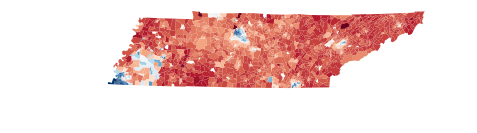

In [15]:
tn_merge.plot(column = "DFrac", cmap = "RdBu", figsize = (3, 3), 
              vmin = 0, vmax = 1, linewidth = 0.02).set_axis_off()

In [16]:
output_geojson(tn_merge.set_geometry(tn_merge.geometry.simplify(10)),
               var = "DFrac", fname = "mapped/tn_2016.geojson")

### Merge to Census Tracts for Analysis

In [17]:
tr_rn = get_tr_rn(usps).to_crs(epsg = epsg)
tn = gpd.read_file(fname + "tennessee.shp").to_crs(epsg = epsg)

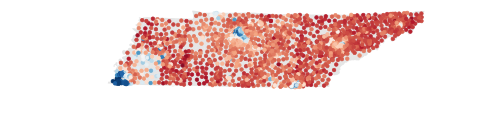

In [18]:
ax = tr_rn.plot(color = "k", alpha = 0.1, figsize = (3, 3))
tn.set_geometry(tn.centroid).plot(markersize = 3, column = "DFrac", cmap = "RdBu", vmin = 0, vmax = 1, ax = ax)
ax.set_axis_off()

In [19]:
merge_tract_number(tr_rn, tn)[["D16", "R16"]].to_csv("votes/tn.csv")

In [20]:
pd.read_csv("votes/tn.csv").head()

,rn,D16,R16
0,0,521.0,324.0
1,1,784.0,849.0
2,2,1180.0,1384.0
3,3,608.0,763.0
4,4,884.0,1047.0


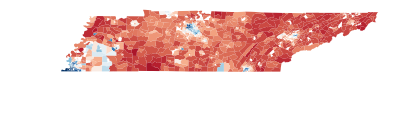

In [21]:
map_sanity_check("tn", 2016)

### Bash Download of All Counties (from Old Site)

In [22]:
# %%bash

# for x in Anderson Bedford Benton Bledsoe Blount Bradley Campbell Cannon Carroll Carter Cheatham Chester Claiborne Clay Cocke Coffee Crockett Cumberland Davidson Decatur DeKalb Dickson Dyer Fayette Fentress Franklin Gibson Giles Grainger Greene Grundy Hamblen Hamilton Hancock Hardeman Hardin Hawkins Haywood Henderson Henry Hickman Houston Humphreys Jackson Jefferson Johnson Knox Lake Lauderdale Lawrence Lewis Lincoln Loudon Macon Madison Marion Marshall Maury McMinn McNairy Meigs Monroe Montgomery Moore Morgan Obion Overton Perry Pickett Polk Putnam Rhea Roane Robertson Rutherford Scott Sequatchie Sevier Shelby Smith Stewart Sullivan Sumner Tipton Trousdale Unicoi Union Van%20Buren Warren Washington Wayne Weakley White Williamson Wilson; do

#   wget http://comptroller.tn.gov/repository/LG/DistrictMaps/$x/Precinct%20Maps/Current%20Voter%20Precinct%20KMZ.zip -O $x.zip

# done

# mkdir tmp/
# for x in *zip; do
#   y=$(echo $x | sed "s/.zip//g" | sed "s/%20//")
#   cp $x tmp/
#   cd tmp
#   unzip -o $x
#   mv Current*.kmz $y.kmz
#   unzip -o $y.kmz
#   if [ -f Current*.kmz ]; then mv Current*.kmz $y.kmz; unzip -o $y.kmz; fi
#   ogr2ogr -f 'ESRI Shapefile' ../$y.shp doc.kml -dim 2
#   cd ..
# done